# Exploring Neural Networks with the MNIST and EMNIST dataset
Here, we will explore neural networks under the MNIST and EMNIST dataset in order to get a good understanding of how accurate machine learning models can get, and what its limits are.

In [78]:
# IMPORTS

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Detect GPU so we can use hardware acceleration
# Prints cuda if using a GPU, prints cpu if we're just using a CPU

# Please note that you must install a version of pytorch
# that supports CUDA, and you must have an NVIDIA GPU

# CUDA:     https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local
# PYTORCH:  https://pytorch.org/get-started/locally/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [33]:
# SETUP OF PATHS AND CONSTANTS

batch_size_train = 64
batch_size_test = 1000

dir_dataset = "/files/"

PATH_DNN_MNIST = "dnn_model_mnist"
PATH_CNN_MNIST = "cnn_model_mnist"
PATH_CNN_EMNIST = "cnn_model_emnist"

def get_model_path(raw_path: str, hyperparameters):
    
    if (hyperparameters == []):
        return raw_path + ".pth"
    
    hyperparameters_str = \
        str(hyperparameters[0]) + "-" + \
        str(hyperparameters[1]) + "-" + \
        str(hyperparameters[2])
    return raw_path + hyperparameters_str.replace(".","_") + ".pth"

In [34]:
# SETUP OF DATASETS

# mnist

mnist_loader_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(dir_dataset, train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)

mnist_loader_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(dir_dataset, train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)

# emnist

emnist_loader_train = torch.utils.data.DataLoader(
    torchvision.datasets.EMNIST(dir_dataset, split='letters', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                                    lambda img: torchvision.transforms.functional.hflip(img),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)

emnist_loader_test = torch.utils.data.DataLoader(
    torchvision.datasets.EMNIST(dir_dataset, split='letters', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                                    lambda img: torchvision.transforms.functional.hflip(img),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)


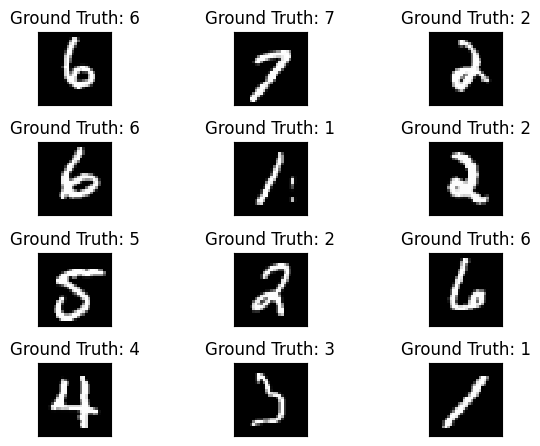

In [35]:
# DISPLAYING THE MNIST DATASET

mnist_label_map = [str(i) for i in range(10)]
mnist_labels_size = len(mnist_label_map)

# Get some test data
examples = enumerate(mnist_loader_test)
batch_idx, (example_data, example_targets) = next(examples)

# Plot the samples
fig = plt.figure()
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {mnist_label_map[example_targets[i].item()]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

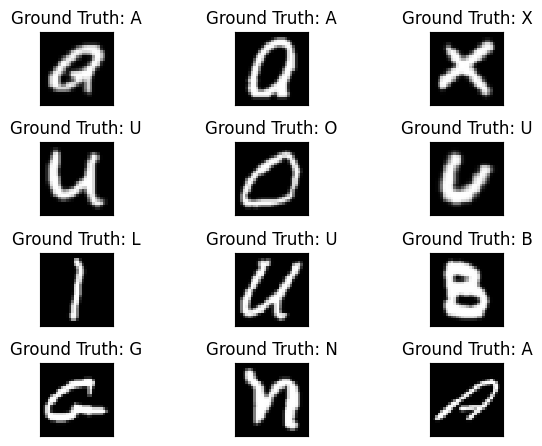

In [36]:
# DISPLAYING THE EMNIST DATASET

emnist_label_map = [0] + [chr(i) for i in range(ord('A'), ord('Z') + 1)]
emnist_labels_size = len(emnist_label_map)

# Get some test data
examples = enumerate(emnist_loader_test)
batch_idx, (example_data, example_targets) = next(examples)

# Plot the samples
fig = plt.figure()
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {emnist_label_map[example_targets[i].item()]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [77]:
# DEFINING THE DEEP NEURAL NETWORK

class NetDNN(nn.Module):
    def __init__(self, labels_size):
        super(NetDNN, self).__init__()
        # Input size for MNIST images (28x28 = 784)
        self.input_size = 28 * 28
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.input_size, 512)  # Input to hidden layer 1
        self.bn1 = nn.BatchNorm1d(512)             # Batch normalization
        
        self.fc2 = nn.Linear(512, 256)             # Hidden layer 2
        self.bn2 = nn.BatchNorm1d(256)             # Batch normalization
        
        self.fc3 = nn.Linear(256, 128)             # Hidden layer 3
        self.bn3 = nn.BatchNorm1d(128)             # Batch normalization
        
        self.fc4 = nn.Linear(128, 64)              # Hidden layer 4
        self.bn4 = nn.BatchNorm1d(64)              # Batch normalization
        
        self.fc5 = nn.Linear(64, labels_size)      # Output layer for 10 classes
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Flatten input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, self.input_size)
        
        # Fully connected layers with ReLU, BatchNorm, and Dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        # Output layer (logits)
        x = self.fc5(x)
        
        # Use log_softmax for classification output
        return F.log_softmax(x, dim=1)


In [ ]:
# DEFINING THE CONVOLUTIONAL NEURAL NETWORK

class NetCNN(nn.Module):
    def __init__(self, labels_size):
        super(NetCNN, self).__init__()
        
        # First convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        # First pass of classification
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        # 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn2 = nn.BatchNorm2d(64)
        
        # Dropout to prevent overfitting
        self.drop = nn.Dropout2d(0.25)
        
        # Third convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)      # Adjust flattened size for pooling
        self.fc2 = nn.Linear(128, labels_size)      # Output layer

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 28x28 -> 14x14
        
        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 14x14 -> 7x7
        
        # Dropout to prevent overfitting
        x = self.drop(x)
        
        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 7x7 -> 3x3
        
        # Flatten for fully connected layers (from 128x3x3 to 1D)
        x = x.view(x.size(0), -1)  # Flatten tensor
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # FC1 + ReLU
        x = self.fc2(x)          # FC2
        
        # Log softmax for classification (probabilities)
        return F.log_softmax(x, dim=1)

In [ ]:
# DEFINING FUNCTIONS FOR INITIALIZATION

# He initialization of weights

def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

# Main training routine

def train_model(model, train_loader, optimizer, epoch):
    model.train()
    epoch_batch_loss_array = []
    # Get each
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # Store results
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))
        epoch_batch_loss_array.append([epoch, batch_idx * len(data), loss.item()])
    return epoch_batch_loss_array

# Run on test data

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    return 'Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset))

# Commence training routine

def run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate=0.01, momentum=0.5):
    # Initialize model weights
    model.apply(weights_init)
    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Store epoch results in a string
    # that we can use to analyze average loss and accuracy
    epoch_results = ""
    # Store data we can use to graph
    epoch_batch_loss_array = []
    # Get initial performance
    epoch_results += test_model(model, test_loader)
    # Train for three epochs
    n_epochs = 3
    for epoch in range(1, n_epochs + 1):
        epoch_batch_loss_array += train_model(model, train_loader, optimizer, epoch)
        epoch_results += test_model(model, test_loader)

    torch.save(model, model_path)

    # --- GRAPHING THE RESULTS

    print(epoch_results)
    
    # Printing array is irrelevant since it will be used in the graph
    # print(epoch_batch_loss_array)

    # Extract batch numbers and loss values
    batch_numbers = [item[1] + (item[0]-1) * len(train_loader.dataset) for item in epoch_batch_loss_array]
    loss_values = [item[2] for item in epoch_batch_loss_array]

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.xlim(-1000, 175000)
    plt.ylim(-0.5, 4)

    # Plot the loss values against batch numbers
    plt.plot(batch_numbers, loss_values, label='Training Loss')

    # Add labels and title
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

    # Return results and batch loss array for data, though
    # it now seems unnecessary due to the plot already being
    # there.
    return epoch_results, epoch_batch_loss_array

# model testing and analysis

def run_and_test_model(model_path, model, test_loader, num_samples, label_map):
    model = torch.load(model_path)
    model.eval()

    data_iter = iter(test_loader)
    example_data, example_targets = next(data_iter)
    example_data, example_targets = example_data.to(device), example_targets.to(device)

    # Get predictions
    with torch.no_grad():
        output = model(example_data)
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities

    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')  # Show grayscale image
        
        # Get GT label
        gt_label = label_map[example_targets[i].item()]
        
        # Get top-3 predictions and their probabilities
        top3_probs, top3_indices = torch.topk(probabilities[i], 3)
        top3_labels = [label_map[idx.item()] for idx in top3_indices]
        top3_text = "\n".join([f"{label} ({prob.item() * 100:.1f}%)" 
                                for label, prob in zip(top3_labels, top3_probs)])
        
        # Display GT and top-3 predictions
        ax.set_title(f"GT: {gt_label}\n{top3_text}", fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [40]:
# ENCAPSULATED FUNCTIONS

# run and train functions return (epoch_results, epoch_batch_loss_array)

def run_and_train_dnn(model_path, train_loader, test_loader, label_map, n_epochs, learning_rate=0.01, momentum=0.5):
    model = NetDNN(len(label_map)).to(device)
    return run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate, momentum)

def run_and_train_cnn(model_path, train_loader, test_loader, label_map, n_epochs, learning_rate=0.01, momentum=0.5):
    model = NetCNN(len(label_map)).to(device)
    return run_and_train_model(model_path, model, train_loader, test_loader, n_epochs, learning_rate, momentum)

# run and test functions show graphs

def run_and_test_dnn(model_path, test_loader, num_samples, label_map):
    model = NetDNN(len(label_map))
    run_and_test_model(model_path, model, test_loader, num_samples, label_map)

def run_and_test_cnn(model_path, test_loader, num_samples, label_map):
    model = NetCNN(len(label_map))
    run_and_test_model(model_path, model, test_loader, num_samples, label_map)

In [79]:
# DNN hyperparameter testing

hyperparameters_list = [
    [3, 0.01, 0.7],
    [3, 0.01, 0.2],
    [3, 0.09, 0.5],
    [3, 0.004, 0.5]
]

# run training and testing functions

def run_and_train_dnn_from_hyperparameters(hyperparameters):
    run_and_train_dnn(
        get_model_path(PATH_DNN_MNIST, hyperparameters), 
        mnist_loader_train, 
        mnist_loader_test,
        mnist_label_map,
        hyperparameters[0],
        hyperparameters[1],
        hyperparameters[2]
        )
def run_and_test_dnn_from_hyperparameters(hyperparameters):
    run_and_test_dnn(
        get_model_path(PATH_DNN_MNIST, hyperparameters),
        mnist_loader_test,
        12,
        mnist_label_map
    )

def run_and_train_cnn_m_from_hyperparameters(hyperparameters):
    run_and_train_cnn(
        get_model_path(PATH_CNN_MNIST, hyperparameters), 
        mnist_loader_train, 
        mnist_loader_test, 
        mnist_label_map,
        hyperparameters[0],
        hyperparameters[1],
        hyperparameters[2]
        )
def run_and_test_cnn_m_from_hyperparameters(hyperparameters):
    run_and_test_cnn(
        get_model_path(PATH_CNN_MNIST, hyperparameters),
        mnist_loader_test,
        12,
        mnist_label_map
    )

def run_and_train_cnn_e_from_hyperparameters(hyperparameters):
    run_and_train_cnn(
        get_model_path(PATH_CNN_EMNIST, hyperparameters), 
        emnist_loader_train, 
        emnist_loader_test, 
        emnist_label_map,
        hyperparameters[0],
        hyperparameters[1],
        hyperparameters[2]
        )
def run_and_test_cnn_e_from_hyperparameters(hyperparameters):
    run_and_test_cnn(
        get_model_path(PATH_CNN_EMNIST, hyperparameters),
        emnist_loader_test,
        12,
        emnist_label_map
    )

## DNN (MNIST)

Train Epoch: 1 [0/60000]	Loss: 3.215478
Train Epoch: 1 [1600/60000]	Loss: 2.181876
Train Epoch: 1 [3200/60000]	Loss: 1.884712
Train Epoch: 1 [4800/60000]	Loss: 1.603320
Train Epoch: 1 [6400/60000]	Loss: 1.410991
Train Epoch: 1 [8000/60000]	Loss: 1.159691
Train Epoch: 1 [9600/60000]	Loss: 1.388916
Train Epoch: 1 [11200/60000]	Loss: 1.002524
Train Epoch: 1 [12800/60000]	Loss: 1.077354
Train Epoch: 1 [14400/60000]	Loss: 0.915227
Train Epoch: 1 [16000/60000]	Loss: 0.931938
Train Epoch: 1 [17600/60000]	Loss: 0.834958
Train Epoch: 1 [19200/60000]	Loss: 0.849348
Train Epoch: 1 [20800/60000]	Loss: 0.752800
Train Epoch: 1 [22400/60000]	Loss: 0.724472
Train Epoch: 1 [24000/60000]	Loss: 0.816907
Train Epoch: 1 [25600/60000]	Loss: 0.922975
Train Epoch: 1 [27200/60000]	Loss: 0.709005
Train Epoch: 1 [28800/60000]	Loss: 0.927832
Train Epoch: 1 [30400/60000]	Loss: 0.447099
Train Epoch: 1 [32000/60000]	Loss: 0.479947
Train Epoch: 1 [33600/60000]	Loss: 0.437373
Train Epoch: 1 [35200/60000]	Loss: 0.73311

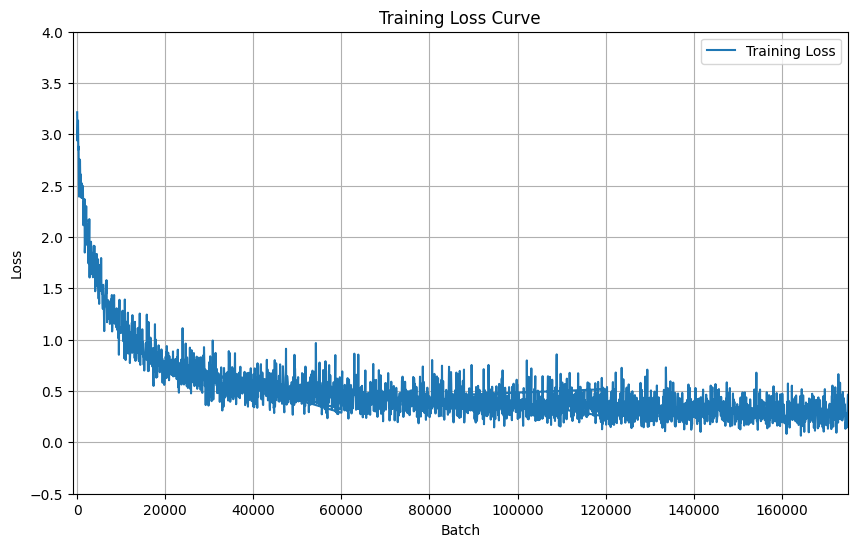

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


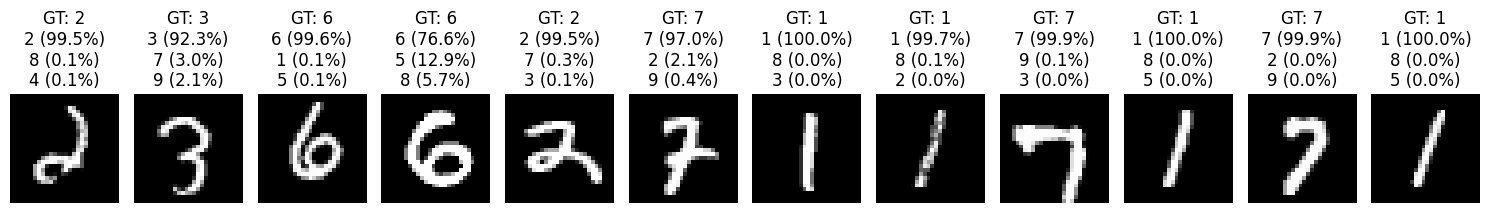

In [42]:
run_and_train_dnn_from_hyperparameters(hyperparameters_list[0])
run_and_test_dnn_from_hyperparameters(hyperparameters_list[0])

Train Epoch: 1 [0/60000]	Loss: 2.966726
Train Epoch: 1 [1600/60000]	Loss: 2.514683
Train Epoch: 1 [3200/60000]	Loss: 2.146746
Train Epoch: 1 [4800/60000]	Loss: 2.123790
Train Epoch: 1 [6400/60000]	Loss: 2.048067
Train Epoch: 1 [8000/60000]	Loss: 1.927669
Train Epoch: 1 [9600/60000]	Loss: 1.511840
Train Epoch: 1 [11200/60000]	Loss: 1.659599
Train Epoch: 1 [12800/60000]	Loss: 1.403898
Train Epoch: 1 [14400/60000]	Loss: 1.262330
Train Epoch: 1 [16000/60000]	Loss: 1.375222
Train Epoch: 1 [17600/60000]	Loss: 1.362321
Train Epoch: 1 [19200/60000]	Loss: 1.079185
Train Epoch: 1 [20800/60000]	Loss: 1.221343
Train Epoch: 1 [22400/60000]	Loss: 1.160712
Train Epoch: 1 [24000/60000]	Loss: 1.152020
Train Epoch: 1 [25600/60000]	Loss: 1.020532
Train Epoch: 1 [27200/60000]	Loss: 0.944517
Train Epoch: 1 [28800/60000]	Loss: 0.894113
Train Epoch: 1 [30400/60000]	Loss: 0.756867
Train Epoch: 1 [32000/60000]	Loss: 1.113597
Train Epoch: 1 [33600/60000]	Loss: 0.978313
Train Epoch: 1 [35200/60000]	Loss: 0.81872

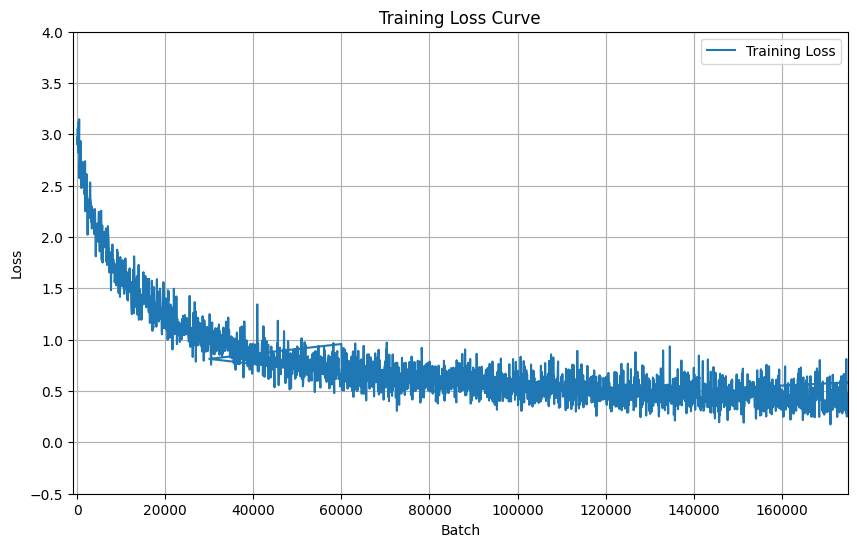

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


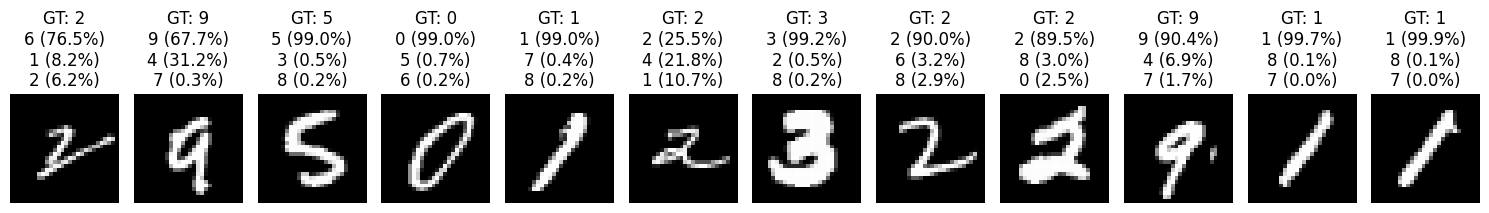

In [43]:
run_and_train_dnn_from_hyperparameters(hyperparameters_list[1])
run_and_test_dnn_from_hyperparameters(hyperparameters_list[1])

Train Epoch: 1 [0/60000]	Loss: 2.834465
Train Epoch: 1 [1600/60000]	Loss: 1.093694
Train Epoch: 1 [3200/60000]	Loss: 0.761666
Train Epoch: 1 [4800/60000]	Loss: 0.807000
Train Epoch: 1 [6400/60000]	Loss: 0.409455
Train Epoch: 1 [8000/60000]	Loss: 0.588915
Train Epoch: 1 [9600/60000]	Loss: 0.360220
Train Epoch: 1 [11200/60000]	Loss: 0.422949
Train Epoch: 1 [12800/60000]	Loss: 0.516359
Train Epoch: 1 [14400/60000]	Loss: 0.379338
Train Epoch: 1 [16000/60000]	Loss: 0.407123
Train Epoch: 1 [17600/60000]	Loss: 0.302019
Train Epoch: 1 [19200/60000]	Loss: 0.211049
Train Epoch: 1 [20800/60000]	Loss: 0.342039
Train Epoch: 1 [22400/60000]	Loss: 0.645342
Train Epoch: 1 [24000/60000]	Loss: 0.329468
Train Epoch: 1 [25600/60000]	Loss: 0.341525
Train Epoch: 1 [27200/60000]	Loss: 0.395650
Train Epoch: 1 [28800/60000]	Loss: 0.325552
Train Epoch: 1 [30400/60000]	Loss: 0.328235
Train Epoch: 1 [32000/60000]	Loss: 0.239030
Train Epoch: 1 [33600/60000]	Loss: 0.417848
Train Epoch: 1 [35200/60000]	Loss: 0.57671

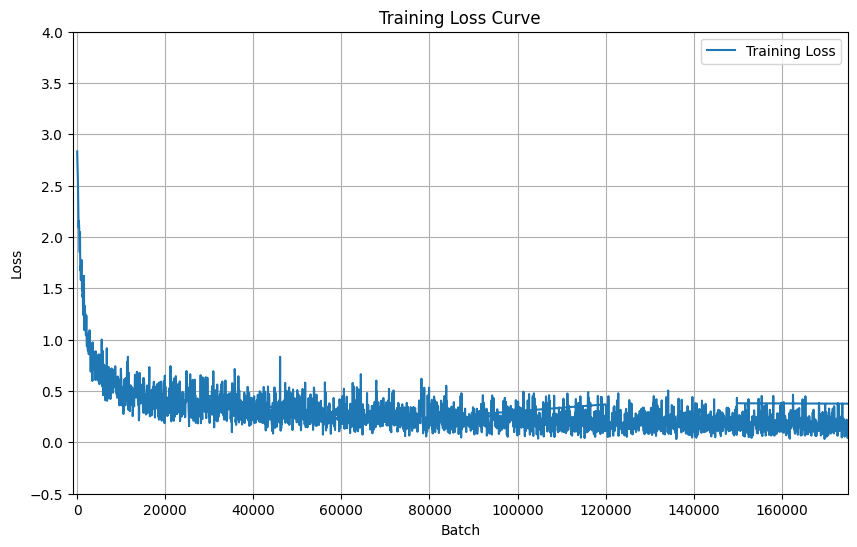

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


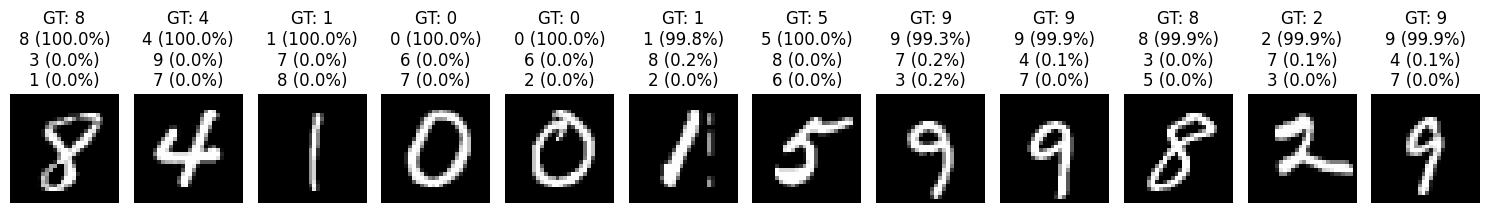

In [44]:
run_and_train_dnn_from_hyperparameters(hyperparameters_list[2])
run_and_test_dnn_from_hyperparameters(hyperparameters_list[2])

Train Epoch: 1 [0/60000]	Loss: 3.033577
Train Epoch: 1 [1600/60000]	Loss: 2.707975
Train Epoch: 1 [3200/60000]	Loss: 2.269837
Train Epoch: 1 [4800/60000]	Loss: 2.016508
Train Epoch: 1 [6400/60000]	Loss: 2.024859
Train Epoch: 1 [8000/60000]	Loss: 1.703316
Train Epoch: 1 [9600/60000]	Loss: 1.839990
Train Epoch: 1 [11200/60000]	Loss: 1.638254
Train Epoch: 1 [12800/60000]	Loss: 1.679975
Train Epoch: 1 [14400/60000]	Loss: 1.534368
Train Epoch: 1 [16000/60000]	Loss: 1.462016
Train Epoch: 1 [17600/60000]	Loss: 1.309171
Train Epoch: 1 [19200/60000]	Loss: 1.527564
Train Epoch: 1 [20800/60000]	Loss: 1.624867
Train Epoch: 1 [22400/60000]	Loss: 1.269689
Train Epoch: 1 [24000/60000]	Loss: 1.344678
Train Epoch: 1 [25600/60000]	Loss: 1.269412
Train Epoch: 1 [27200/60000]	Loss: 1.236733
Train Epoch: 1 [28800/60000]	Loss: 1.301143
Train Epoch: 1 [30400/60000]	Loss: 1.287368
Train Epoch: 1 [32000/60000]	Loss: 1.106968
Train Epoch: 1 [33600/60000]	Loss: 0.995094
Train Epoch: 1 [35200/60000]	Loss: 1.03898

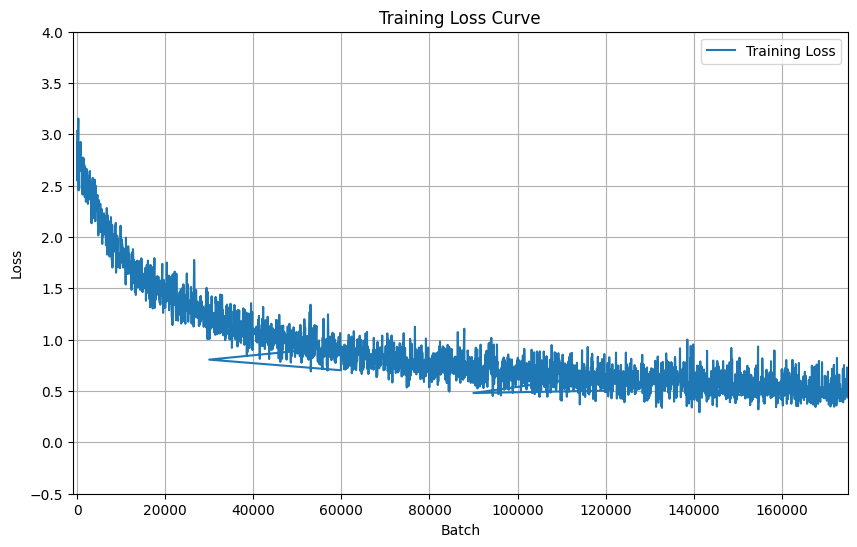

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


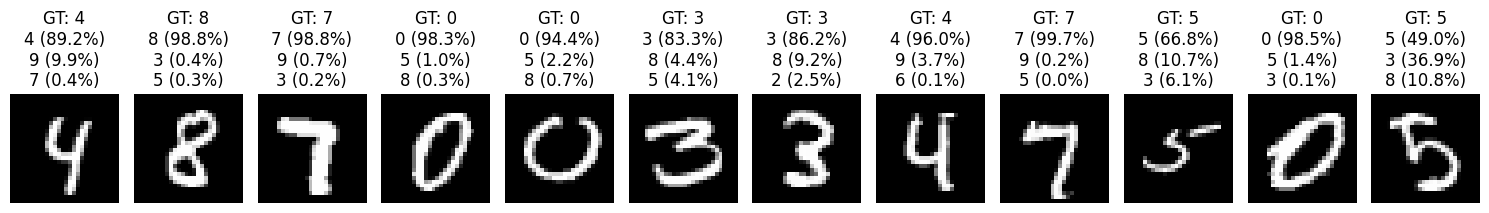

In [45]:
run_and_train_dnn_from_hyperparameters(hyperparameters_list[3])
run_and_test_dnn_from_hyperparameters(hyperparameters_list[3])

## CNN (MNIST) RESULTS

c:\Users\jluis\OneDrive\Desktop\CSCI\167_proj\.venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000]	Loss: 3.469307
Train Epoch: 1 [1600/60000]	Loss: 0.563400
Train Epoch: 1 [3200/60000]	Loss: 0.363658
Train Epoch: 1 [4800/60000]	Loss: 0.244710
Train Epoch: 1 [6400/60000]	Loss: 0.223937
Train Epoch: 1 [8000/60000]	Loss: 0.222922
Train Epoch: 1 [9600/60000]	Loss: 0.348029
Train Epoch: 1 [11200/60000]	Loss: 0.133904
Train Epoch: 1 [12800/60000]	Loss: 0.065229
Train Epoch: 1 [14400/60000]	Loss: 0.051397
Train Epoch: 1 [16000/60000]	Loss: 0.123741
Train Epoch: 1 [17600/60000]	Loss: 0.121649
Train Epoch: 1 [19200/60000]	Loss: 0.115560
Train Epoch: 1 [20800/60000]	Loss: 0.140742
Train Epoch: 1 [22400/60000]	Loss: 0.063145
Train Epoch: 1 [24000/60000]	Loss: 0.067872
Train Epoch: 1 [25600/60000]	Loss: 0.118177
Train Epoch: 1 [27200/60000]	Loss: 0.093979
Train Epoch: 1 [28800/60000]	Loss: 0.048943
Train Epoch: 1 [30400/60000]	Loss: 0.068035
Train Epoch: 1 [32000/60000]	Loss: 0.028069
Train Epoch: 1 [33600/60000]	Loss: 0.058739
Train Epoch: 1 [35200/60000]	Loss: 0.12897

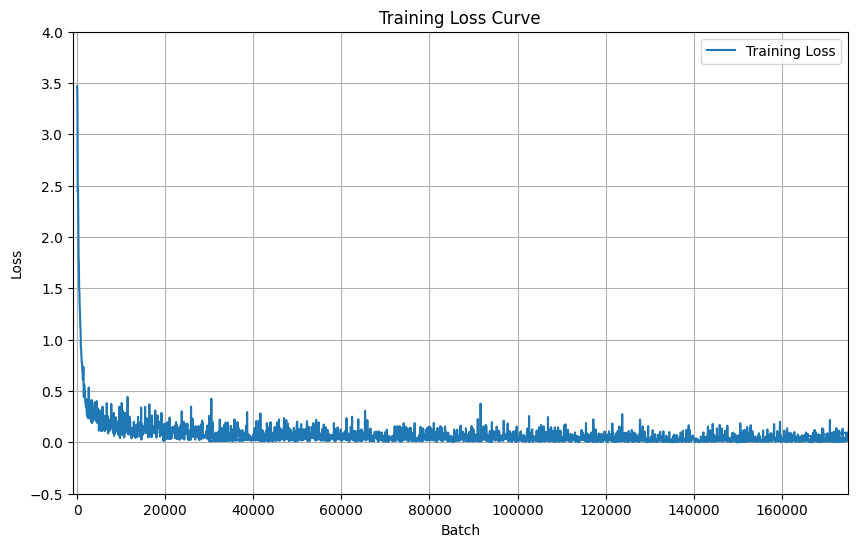

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


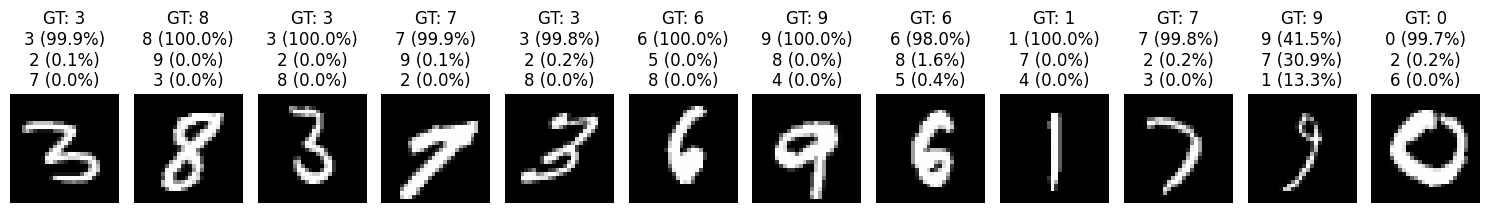

In [46]:
run_and_train_cnn_m_from_hyperparameters(hyperparameters_list[0])
run_and_test_cnn_m_from_hyperparameters(hyperparameters_list[0])

Train Epoch: 1 [0/60000]	Loss: 2.781343
Train Epoch: 1 [1600/60000]	Loss: 0.924565
Train Epoch: 1 [3200/60000]	Loss: 0.615980
Train Epoch: 1 [4800/60000]	Loss: 0.566381
Train Epoch: 1 [6400/60000]	Loss: 0.447033
Train Epoch: 1 [8000/60000]	Loss: 0.166635
Train Epoch: 1 [9600/60000]	Loss: 0.219152
Train Epoch: 1 [11200/60000]	Loss: 0.249331
Train Epoch: 1 [12800/60000]	Loss: 0.261504
Train Epoch: 1 [14400/60000]	Loss: 0.377761
Train Epoch: 1 [16000/60000]	Loss: 0.148195
Train Epoch: 1 [17600/60000]	Loss: 0.141968
Train Epoch: 1 [19200/60000]	Loss: 0.180575
Train Epoch: 1 [20800/60000]	Loss: 0.113380
Train Epoch: 1 [22400/60000]	Loss: 0.139937
Train Epoch: 1 [24000/60000]	Loss: 0.108715
Train Epoch: 1 [25600/60000]	Loss: 0.092226
Train Epoch: 1 [27200/60000]	Loss: 0.108091
Train Epoch: 1 [28800/60000]	Loss: 0.127251
Train Epoch: 1 [30400/60000]	Loss: 0.117386
Train Epoch: 1 [32000/60000]	Loss: 0.063585
Train Epoch: 1 [33600/60000]	Loss: 0.042475
Train Epoch: 1 [35200/60000]	Loss: 0.20111

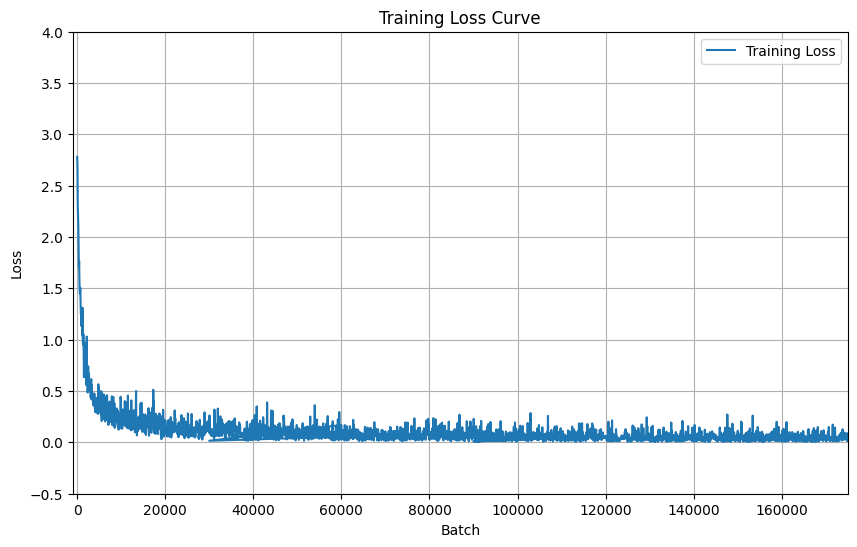

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


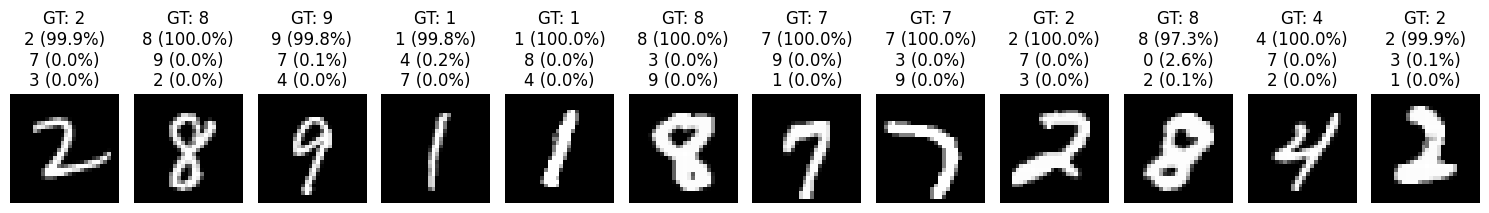

In [47]:
run_and_train_cnn_m_from_hyperparameters(hyperparameters_list[1])
run_and_test_cnn_m_from_hyperparameters(hyperparameters_list[1])

Train Epoch: 1 [0/60000]	Loss: 2.658492
Train Epoch: 1 [1600/60000]	Loss: 1.053529
Train Epoch: 1 [3200/60000]	Loss: 0.584274
Train Epoch: 1 [4800/60000]	Loss: 0.413857
Train Epoch: 1 [6400/60000]	Loss: 0.576328
Train Epoch: 1 [8000/60000]	Loss: 0.213317
Train Epoch: 1 [9600/60000]	Loss: 0.220475
Train Epoch: 1 [11200/60000]	Loss: 0.112350
Train Epoch: 1 [12800/60000]	Loss: 0.207169
Train Epoch: 1 [14400/60000]	Loss: 0.232930
Train Epoch: 1 [16000/60000]	Loss: 0.104085
Train Epoch: 1 [17600/60000]	Loss: 0.248006
Train Epoch: 1 [19200/60000]	Loss: 0.412254
Train Epoch: 1 [20800/60000]	Loss: 0.141169
Train Epoch: 1 [22400/60000]	Loss: 0.144789
Train Epoch: 1 [24000/60000]	Loss: 0.141479
Train Epoch: 1 [25600/60000]	Loss: 0.066978
Train Epoch: 1 [27200/60000]	Loss: 0.059030
Train Epoch: 1 [28800/60000]	Loss: 0.165777
Train Epoch: 1 [30400/60000]	Loss: 0.124171
Train Epoch: 1 [32000/60000]	Loss: 0.023534
Train Epoch: 1 [33600/60000]	Loss: 0.157831
Train Epoch: 1 [35200/60000]	Loss: 0.13512

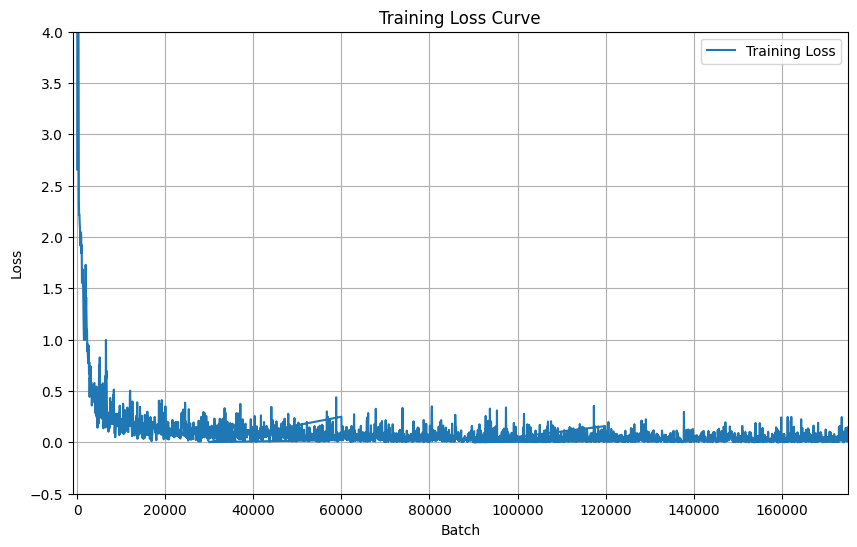

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


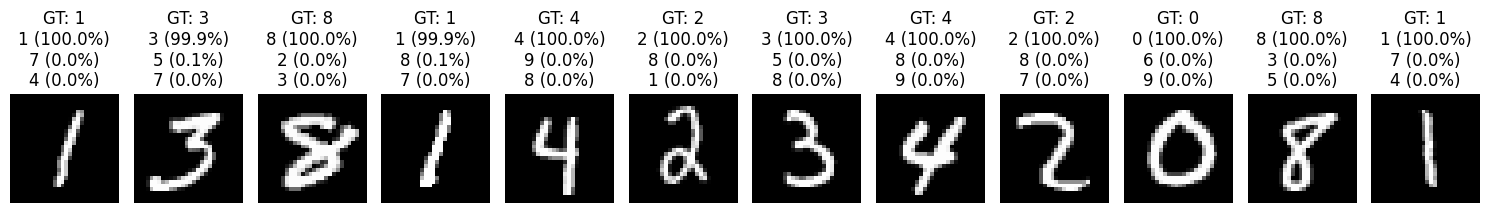

In [48]:
run_and_train_cnn_m_from_hyperparameters(hyperparameters_list[2])
run_and_test_cnn_m_from_hyperparameters(hyperparameters_list[2])

Train Epoch: 1 [0/60000]	Loss: 2.955446
Train Epoch: 1 [1600/60000]	Loss: 1.043146
Train Epoch: 1 [3200/60000]	Loss: 0.583358
Train Epoch: 1 [4800/60000]	Loss: 0.229893
Train Epoch: 1 [6400/60000]	Loss: 0.321322
Train Epoch: 1 [8000/60000]	Loss: 0.193032
Train Epoch: 1 [9600/60000]	Loss: 0.201894
Train Epoch: 1 [11200/60000]	Loss: 0.177758
Train Epoch: 1 [12800/60000]	Loss: 0.163698
Train Epoch: 1 [14400/60000]	Loss: 0.091514
Train Epoch: 1 [16000/60000]	Loss: 0.218038
Train Epoch: 1 [17600/60000]	Loss: 0.169216
Train Epoch: 1 [19200/60000]	Loss: 0.216608
Train Epoch: 1 [20800/60000]	Loss: 0.205985
Train Epoch: 1 [22400/60000]	Loss: 0.121307
Train Epoch: 1 [24000/60000]	Loss: 0.192651
Train Epoch: 1 [25600/60000]	Loss: 0.183892
Train Epoch: 1 [27200/60000]	Loss: 0.103661
Train Epoch: 1 [28800/60000]	Loss: 0.141996
Train Epoch: 1 [30400/60000]	Loss: 0.120277
Train Epoch: 1 [32000/60000]	Loss: 0.090356
Train Epoch: 1 [33600/60000]	Loss: 0.087320
Train Epoch: 1 [35200/60000]	Loss: 0.11195

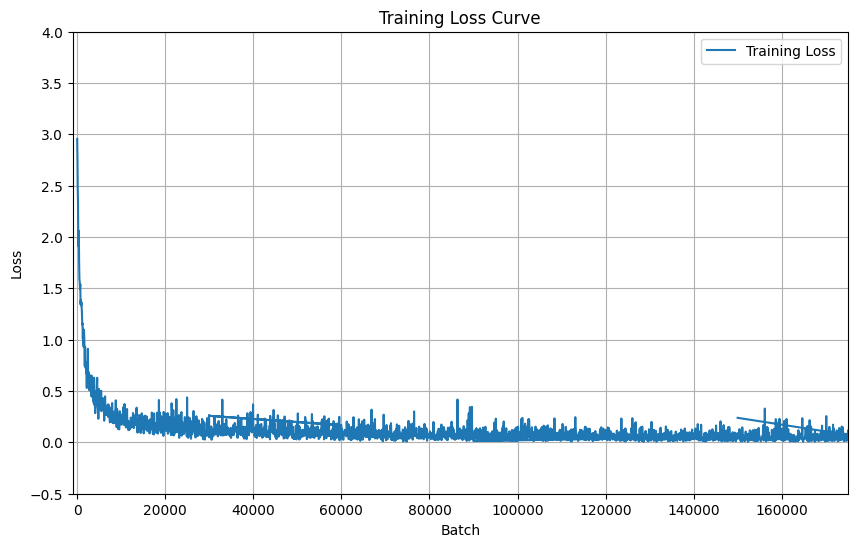

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


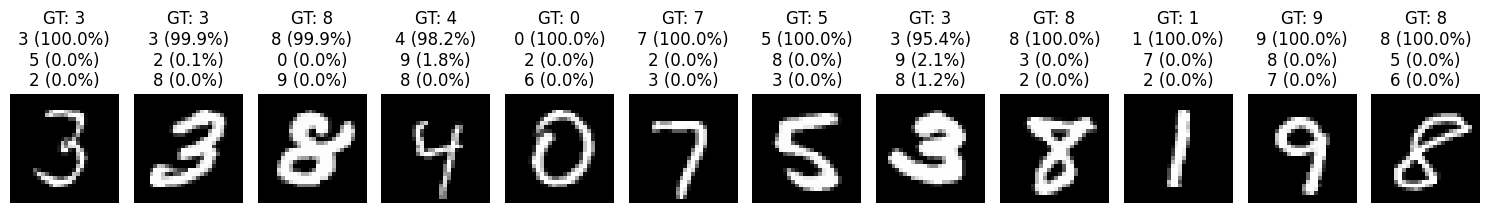

In [49]:
run_and_train_cnn_m_from_hyperparameters(hyperparameters_list[3])
run_and_test_cnn_m_from_hyperparameters(hyperparameters_list[3])

## CNN (EMNIST) RESULTS

Train Epoch: 1 [0/124800]	Loss: 4.170940
Train Epoch: 1 [1600/124800]	Loss: 1.740733
Train Epoch: 1 [3200/124800]	Loss: 0.879621
Train Epoch: 1 [4800/124800]	Loss: 1.385875
Train Epoch: 1 [6400/124800]	Loss: 0.865470
Train Epoch: 1 [8000/124800]	Loss: 0.731355
Train Epoch: 1 [9600/124800]	Loss: 0.944143
Train Epoch: 1 [11200/124800]	Loss: 0.448513
Train Epoch: 1 [12800/124800]	Loss: 0.627112
Train Epoch: 1 [14400/124800]	Loss: 0.338778
Train Epoch: 1 [16000/124800]	Loss: 0.648457
Train Epoch: 1 [17600/124800]	Loss: 0.539459
Train Epoch: 1 [19200/124800]	Loss: 0.495309
Train Epoch: 1 [20800/124800]	Loss: 0.527762
Train Epoch: 1 [22400/124800]	Loss: 0.591168
Train Epoch: 1 [24000/124800]	Loss: 0.415543
Train Epoch: 1 [25600/124800]	Loss: 0.671159
Train Epoch: 1 [27200/124800]	Loss: 0.412948
Train Epoch: 1 [28800/124800]	Loss: 0.386386
Train Epoch: 1 [30400/124800]	Loss: 0.737033
Train Epoch: 1 [32000/124800]	Loss: 0.708307
Train Epoch: 1 [33600/124800]	Loss: 0.215564
Train Epoch: 1 [3520

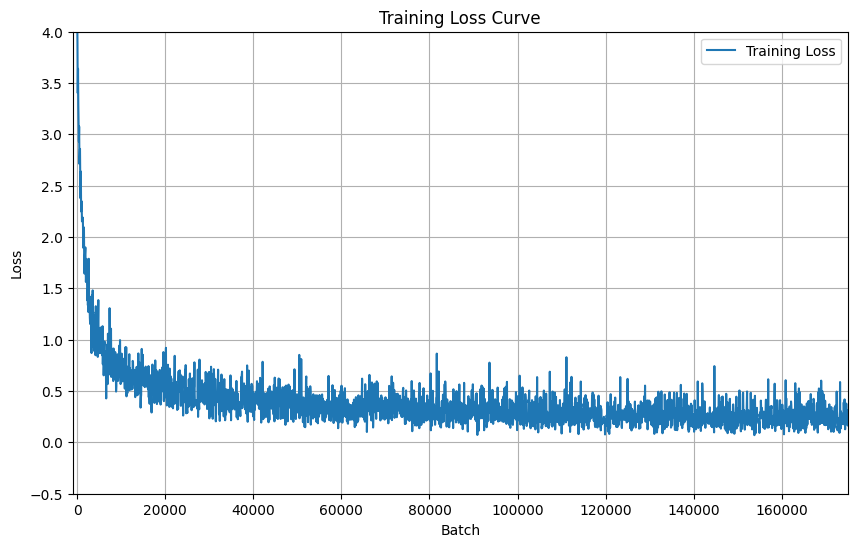

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


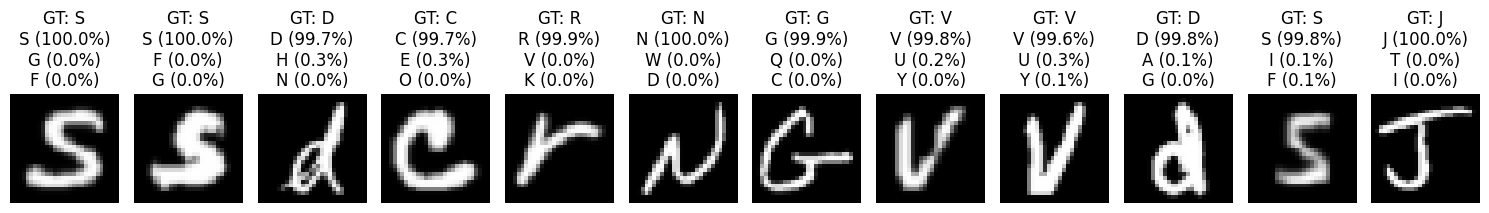

In [81]:
run_and_train_cnn_e_from_hyperparameters(hyperparameters_list[0])
run_and_test_cnn_e_from_hyperparameters(hyperparameters_list[0])

Train Epoch: 1 [0/124800]	Loss: 4.215183
Train Epoch: 1 [1600/124800]	Loss: 2.512371
Train Epoch: 1 [3200/124800]	Loss: 1.752789
Train Epoch: 1 [4800/124800]	Loss: 1.818281
Train Epoch: 1 [6400/124800]	Loss: 1.052891
Train Epoch: 1 [8000/124800]	Loss: 1.118313
Train Epoch: 1 [9600/124800]	Loss: 0.897223
Train Epoch: 1 [11200/124800]	Loss: 0.941294
Train Epoch: 1 [12800/124800]	Loss: 0.878599
Train Epoch: 1 [14400/124800]	Loss: 0.597942
Train Epoch: 1 [16000/124800]	Loss: 0.638101
Train Epoch: 1 [17600/124800]	Loss: 0.711645
Train Epoch: 1 [19200/124800]	Loss: 0.751885
Train Epoch: 1 [20800/124800]	Loss: 0.864437
Train Epoch: 1 [22400/124800]	Loss: 0.464093
Train Epoch: 1 [24000/124800]	Loss: 0.726921
Train Epoch: 1 [25600/124800]	Loss: 0.566750
Train Epoch: 1 [27200/124800]	Loss: 0.562527
Train Epoch: 1 [28800/124800]	Loss: 0.618109
Train Epoch: 1 [30400/124800]	Loss: 0.613325
Train Epoch: 1 [32000/124800]	Loss: 0.586323
Train Epoch: 1 [33600/124800]	Loss: 0.546134
Train Epoch: 1 [3520

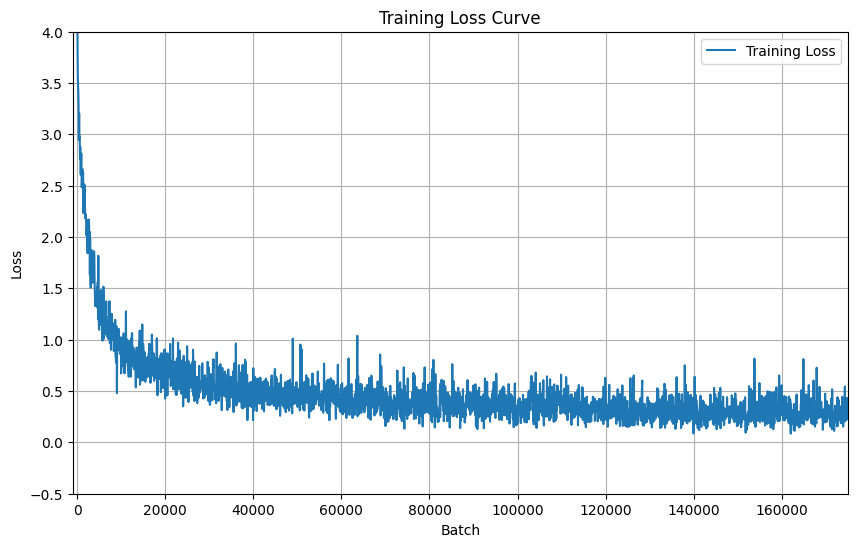

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


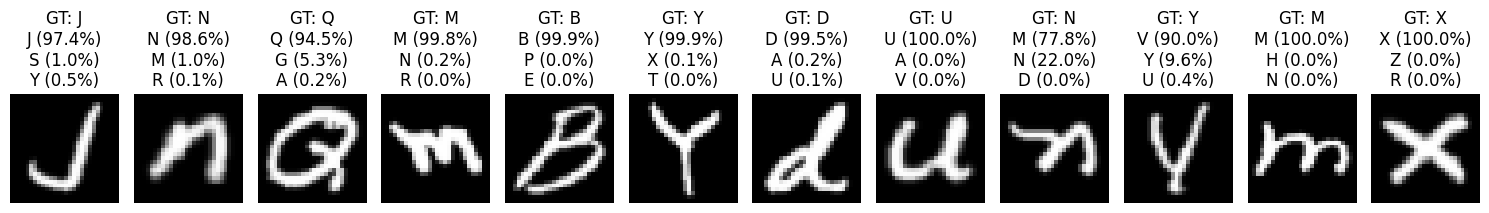

In [82]:
run_and_train_cnn_e_from_hyperparameters(hyperparameters_list[1])
run_and_test_cnn_e_from_hyperparameters(hyperparameters_list[1])

Train Epoch: 1 [0/124800]	Loss: 4.708179
Train Epoch: 1 [1600/124800]	Loss: 2.809337
Train Epoch: 1 [3200/124800]	Loss: 1.923696
Train Epoch: 1 [4800/124800]	Loss: 1.243056
Train Epoch: 1 [6400/124800]	Loss: 0.977002
Train Epoch: 1 [8000/124800]	Loss: 1.118564
Train Epoch: 1 [9600/124800]	Loss: 1.344528
Train Epoch: 1 [11200/124800]	Loss: 1.072796
Train Epoch: 1 [12800/124800]	Loss: 0.626264
Train Epoch: 1 [14400/124800]	Loss: 0.768206
Train Epoch: 1 [16000/124800]	Loss: 0.720976
Train Epoch: 1 [17600/124800]	Loss: 0.497684
Train Epoch: 1 [19200/124800]	Loss: 0.453179
Train Epoch: 1 [20800/124800]	Loss: 0.462522
Train Epoch: 1 [22400/124800]	Loss: 0.339227
Train Epoch: 1 [24000/124800]	Loss: 0.383342
Train Epoch: 1 [25600/124800]	Loss: 0.468235
Train Epoch: 1 [27200/124800]	Loss: 0.713755
Train Epoch: 1 [28800/124800]	Loss: 0.319521
Train Epoch: 1 [30400/124800]	Loss: 0.434375
Train Epoch: 1 [32000/124800]	Loss: 0.415797
Train Epoch: 1 [33600/124800]	Loss: 0.322071
Train Epoch: 1 [3520

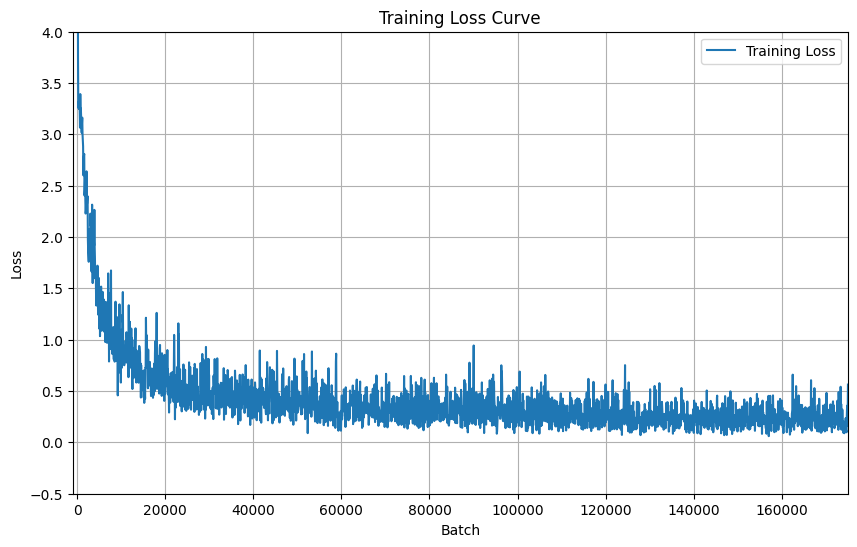

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


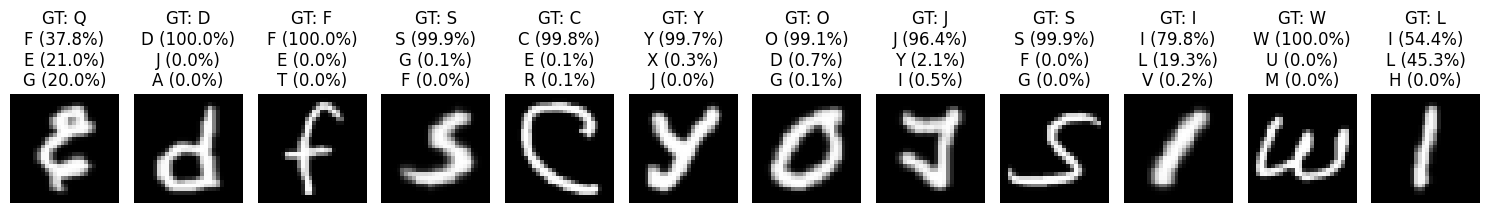

In [83]:
run_and_train_cnn_e_from_hyperparameters(hyperparameters_list[2])
run_and_test_cnn_e_from_hyperparameters(hyperparameters_list[2])

Train Epoch: 1 [0/124800]	Loss: 4.282713
Train Epoch: 1 [1600/124800]	Loss: 2.492768
Train Epoch: 1 [3200/124800]	Loss: 2.046471
Train Epoch: 1 [4800/124800]	Loss: 1.810984
Train Epoch: 1 [6400/124800]	Loss: 1.669750
Train Epoch: 1 [8000/124800]	Loss: 1.197420
Train Epoch: 1 [9600/124800]	Loss: 1.182354
Train Epoch: 1 [11200/124800]	Loss: 0.879602
Train Epoch: 1 [12800/124800]	Loss: 0.826253
Train Epoch: 1 [14400/124800]	Loss: 1.015722
Train Epoch: 1 [16000/124800]	Loss: 1.099689
Train Epoch: 1 [17600/124800]	Loss: 0.742400
Train Epoch: 1 [19200/124800]	Loss: 0.818033
Train Epoch: 1 [20800/124800]	Loss: 0.828055
Train Epoch: 1 [22400/124800]	Loss: 0.674973
Train Epoch: 1 [24000/124800]	Loss: 1.005441
Train Epoch: 1 [25600/124800]	Loss: 0.555481
Train Epoch: 1 [27200/124800]	Loss: 0.741593
Train Epoch: 1 [28800/124800]	Loss: 0.635207
Train Epoch: 1 [30400/124800]	Loss: 0.706364
Train Epoch: 1 [32000/124800]	Loss: 0.707759
Train Epoch: 1 [33600/124800]	Loss: 0.589632
Train Epoch: 1 [3520

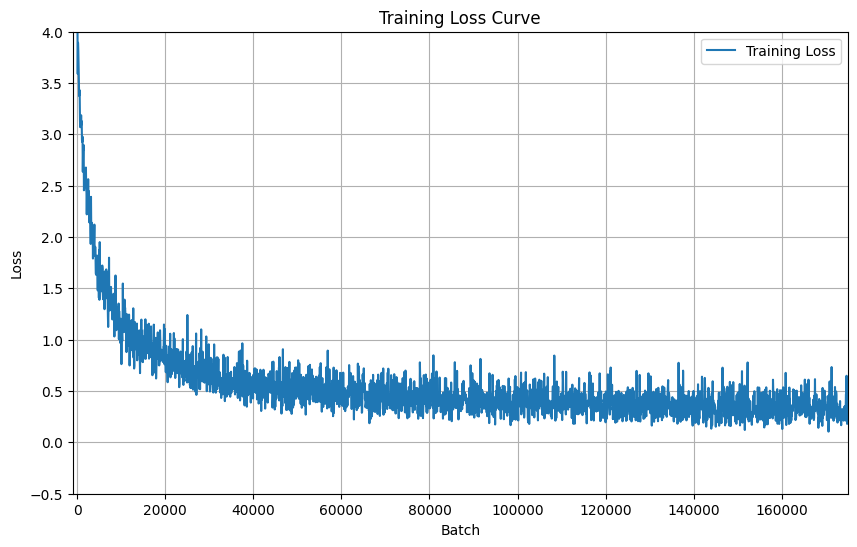

C:\Users\jluis\AppData\Local\Temp\ipykernel_29304\4064332402.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


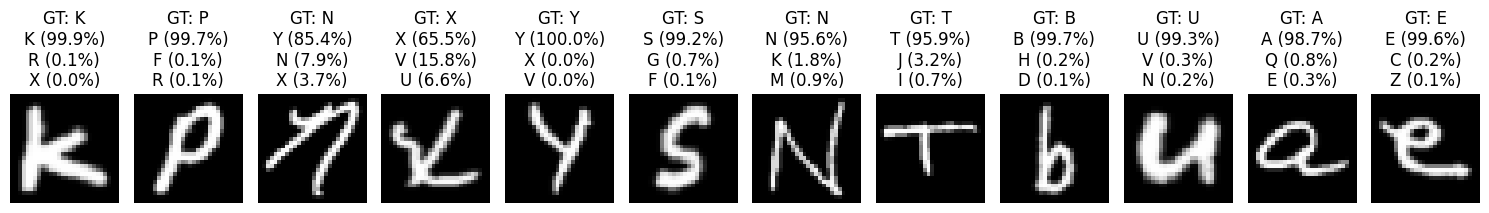

In [84]:
run_and_train_cnn_e_from_hyperparameters(hyperparameters_list[3])
run_and_test_cnn_e_from_hyperparameters(hyperparameters_list[3])